In [73]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests
import math
import tensorflow as tf
import random

from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Membuat dataset latih dan uji


In [75]:
X = []
Y = []

input_shape = (96, 96, 3)
for subset in ('../train', '../test'):
    path_to_subset = 'D:/program/Smt4/pcd/praktikum/project/train'
    for folder in os.listdir(path_to_subset):
        for image in os.listdir(os.path.join(path_to_subset, folder)): 
            path_to_image = os.path.join(path_to_subset, folder, image)

            # Membaca Gambar dan Label
            image = cv.imread(path_to_image)

            # Mengubah Ukuran Gambar
            image = cv.resize(image, (input_shape[1], input_shape[0]))
            label = re.findall(r'\w+\_\w+', path_to_image)[0].split('_')

            # Menyimpan Gambar dan Label
            X.append(image)
            Y.append(label)

# Normalisasi Gambar
X = np.array(X) / 255.0
Y = np.array(Y)

# Melakukan one-hot encoding pada label yang memiliki multiple kategori
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y)

print(mlb.classes_)
print(Y[0])

['black' 'blue' 'brown' 'green' 'pants' 'red' 'shorts' 'white']
[1 0 0 0 1 0 0 0]


Kode di atas merupakan contoh bagaimana dataset gambar dapat dibaca, diubah ukurannya, dan labelnya disimpan dalam format yang tepat untuk digunakan dalam pelatihan model. Preprocessing yang dilakukan pada kode di atas, yaitu membaca gambar dan label, mengubah ukuran gambar, menyimpan gambar dan label, normalisasi gambar, dan melakukan pengubahan label ke angka biner. Di bawah ini adalah penjelasan kode per baris:
1. `X = []` dan `Y = []`: Membuat list kosong `X` untuk menyimpan gambar dan `Y` untuk menyimpan label.
2. `input_shape = (96, 96, 3)`: Mendefinisikan ukuran yang diinginkan untuk gambar input, yaitu 96x96 piksel dengan 3 saluran warna (RGB).
3. `for subset in ('../train', '../test'):`: Melakukan iterasi untuk setiap subset data, dalam hal ini `train` dan `test`.
4. `path_to_subset = 'D:/program/Smt4/pcd/praktikum/project/train'`: Menyimpan path direktori ke subset data. Anda perlu mengubahnya sesuai dengan lokasi penyimpanan dataset di komputer Anda.
5. `for folder in os.listdir(path_to_subset):`: Melakukan iterasi untuk setiap folder di dalam subset data.
6. `for image in os.listdir(os.path.join(path_to_subset, folder)):`: Melakukan iterasi untuk setiap file gambar di dalam folder.
7. `path_to_image = os.path.join(path_to_subset, folder, image)`: Menggabungkan path direktori dengan path gambar untuk membaca gambar.
8. `image = cv.imread(path_to_image)`: Membaca gambar menggunakan OpenCV dan menyimpannya dalam variabel `image`.
9. `image = cv.resize(image, (input_shape[1], input_shape[0]))`: Mengubah ukuran gambar menjadi `input_shape` yang telah ditentukan sebelumnya menggunakan fungsi `cv.resize()` dari OpenCV.
10. `label = re.findall(r'\w+\_\w+', path_to_image)[0].split('_')`: Mengambil label dari nama file gambar dengan menggunakan ekspresi reguler (regular expression) untuk menemukan pola `kata_kata` pada nama file gambar. Misalnya, jika nama file gambar adalah "cat_dog.jpg", maka label akan berisi `['cat', 'dog']`.
11. `X.append(image)` dan `Y.append(label)`: Menyimpan gambar ke dalam list `X` dan label ke dalam list `Y`.
12. Setelah selesai membaca dan menyimpan semua gambar dan label, `X` dan `Y` berisi data yang telah dibaca.
13. `X = np.array(X) / 255.0`: Mengubah list `X` menjadi array numpy dan membaginya dengan 255 untuk melakukan normalisasi gambar. Ini dilakukan untuk mengubah rentang nilai piksel dari 0-255 menjadi 0-1.
14. `Y = np.array(Y)`: Mengubah list `Y` menjadi array numpy.
15. `mlb = MultiLabelBinarizer()`: Membuat objek `MultiLabelBinarizer` dari scikit-learn untuk melakukan one-hot encoding pada label yang memiliki multiple kategori.
16. `Y = mlb.fit_transform(Y)`: Melakukan one-hot encoding pada label menggunakan objek `MultiLabelBinarizer`. Label yang memiliki multiple kategori akan diubah menjadi vektor biner.
17. `print(mlb.classes_)`: Mencetak semua kelas yang muncul dalam label.
18. `print(Y[0])`: Mencetak vektor biner label pertama dari dataset.
Dengan demikian, kode di atas membaca gambar-gambar dari direktori, mengubahnya menjadi format yang sesuai, dan melakukan normalisasi serta one-hot encoding pada label. Hal ini mempersiapkan data untuk digunakan dalam pelatihan model yang membutuhkan gambar dan label dalam format yang sesuai.

# Proses Augmentasi Data

In [76]:
x, test_x, y, test_y = train_test_split(X, Y, test_size=0.1, stratify=Y, shuffle=True, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=1)

print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)


rotation_range = 45
width_shift_range = 0.1
height_shift_range = 0.1
zoom_range = 0.2
horizontal_flip = True
validation_split = 0.2


def augmentasi_data(image):
    
    # Rotasi Gmabar
    angle = random.uniform(-rotation_range, rotation_range)
    angle_rad = angle * (np.pi / 180)
    image_rotated = np.zeros(image.shape, dtype=image.dtype)
    rows, cols = image.shape[:2]
    cx, cy = cols // 2, rows // 2
    for i in range(rows):
        for j in range(cols):
            x = int((i - cx) * np.cos(angle_rad) - (j - cy) * np.sin(angle_rad) + cx)
            y = int((i - cx) * np.sin(angle_rad) + (j - cy) * np.cos(angle_rad) + cy)
            if 0 <= x < rows and 0 <= y < cols:
                image_rotated[x, y] = image[i, j]
    
    # Pergeseran Secara Horizontal
    shift_w = random.uniform(-width_shift_range, width_shift_range)
    width_shift = int(shift_w * image_rotated.shape[1])
    image_shifted_w = custom_roll(image_rotated, width_shift, axis=1)
    
    # Pergeseran Secara Vertikal
    shift_h = random.uniform(-height_shift_range, height_shift_range)
    height_shift = int(shift_h * image_shifted_w.shape[0])
    image_shifted_h = custom_roll(image_shifted_w, height_shift, axis=0)
    
    # Mengubah Ukuran Gambar
    zoom_factor = random.uniform(1 - zoom_range, 1 + zoom_range)
    height, width = image_shifted_h.shape[:2]
    zoomed_width = int(width * zoom_factor)
    zoomed_height = int(height * zoom_factor)
    image_zoomed = cv.resize(image_shifted_h, (zoomed_width, zoomed_height))
    image_cropped = image_zoomed[:height, :width]
    
    # Membalik Gambar Secara Horizontal (Flip Horizontal)
    if horizontal_flip and random.random() < 0.5:
        image_flipped = custom_fliplr(image_cropped)
    else:
        image_flipped = image_cropped
    
    return image_flipped


def custom_roll(image, shift, axis):
    if shift == 0:
        return image

    if axis == 0:
        if shift > 0:
            image[shift:, :, :] = image[:-shift, :, :]
            image[:shift, :, :] = np.zeros(image[:shift, :, :].shape, dtype=image.dtype)
        else:
            image[:shift, :, :] = image[-shift:, :, :]
            image[shift:, :, :] = np.zeros(image[shift:, :, :].shape, dtype=image.dtype)
    elif axis == 1:
        if shift > 0:
            image[:, shift:, :] = image[:, :-shift, :]
            image[:, :shift, :] = np.zeros(image[:, :shift, :].shape, dtype=image.dtype)
        else:
            image[:, :shift, :] = image[:, -shift:, :]
            image[:, shift:, :] = np.zeros(image[:, shift:, :].shape, dtype=image.dtype)
    else:
        raise ValueError("Invalid axis value. Expected 0 or 1.")

    return image

def custom_fliplr(image):
    return image[:, ::-1, :]


augmented_train_x = []
augmented_train_y = []
for i in range(len(train_x)):
    # Augmentasi Data
    augmented_image = augmentasi_data(train_x[i])
    augmented_train_x.append(augmented_image)
    augmented_train_y.append(train_y[i])

augmented_train_x = np.array(augmented_train_x, dtype=object)
augmented_train_y = np.array(augmented_train_y)

augmented_train_x, val_x_augmented, augmented_train_y, val_y_augmented = train_test_split(
    augmented_train_x, augmented_train_y, test_size=validation_split, stratify=augmented_train_y, random_state=1
)


(1800, 96, 96, 3) (200, 96, 96, 3) (1800, 8) (200, 8)
(1440, 96, 96, 3) (360, 96, 96, 3) (1440, 8) (360, 8)


Kode di atas digunakan untuk membagi dataset menjadi subset pelatihan, validasi, dan pengujian, serta mengimplementasikan augmentasi data. Preprocessing dari kode di atas, yaitu melakukan rotasi gambar, menggeser gambar secara horizontal dan vertikal, mengubah ukuran gambar, membalik gambar secara horizontal (flip horizontal), dan melakukan augmentasi data. Berikut adalah penjelasan kode per baris:
1. `x, test_x, y, test_y = train_test_split(X, Y, test_size=0.1, stratify=Y, shuffle=True, random_state=1)`: Memisahkan dataset `X` dan `Y` menjadi subset pelatihan (`x` dan `y`) dan subset pengujian (`test_x` dan `test_y`). Subset pengujian memiliki ukuran 10% dari dataset asli. Parameter `stratify=Y` memastikan bahwa proporsi kelas dalam subset pelatihan dan pengujian tetap sama. `shuffle=True` mengacak urutan data sebelum membagi, dan `random_state=1` digunakan untuk memastikan hasil acak yang konsisten setiap kali kode dijalankan.
2. `train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=1)`: Memisahkan subset pelatihan (`x` dan `y`) menjadi subset pelatihan aktual (`train_x` dan `train_y`) dan subset validasi (`val_x` dan `val_y`). Subset validasi memiliki ukuran 20% dari subset pelatihan. Parameter `stratify=y` memastikan bahwa proporsi kelas dalam subset pelatihan dan validasi tetap sama.
3. `print(x.shape, test_x.shape, y.shape, test_y.shape)`: Mencetak dimensi dari setiap subset untuk memeriksa ukuran data yang telah dibagi.
4. `print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)`: Mencetak dimensi dari subset pelatihan dan validasi untuk memeriksa ukuran data yang telah dibagi.
5. `rotation_range = 45`, `width_shift_range = 0.1`, `height_shift_range = 0.1`, `zoom_range = 0.2`, `horizontal_flip = True`, `validation_split = 0.2`: Mendefinisikan parameter-parameter untuk augmentasi data. Parameter ini akan digunakan dalam fungsi `augmentasi_data()`.
6. `def augmentasi_data(image)`: Mendefinisikan fungsi `augmentasi_data` yang akan menerapkan berbagai transformasi pada gambar untuk menghasilkan variasi data tambahan.
7. Fungsi `augmentasi_data()` memiliki beberapa langkah sebagai berikut:
   a. Rotasi Gambar: Mengacak sudut rotasi antara -45 derajat hingga 45 derajat. Menggunakan transformasi geometri untuk memutar gambar sebesar sudut rotasi yang diacak.
   b. Pergeseran Secara Horizontal dan Vertikal: Mengacak nilai pergeseran secara horizontal dan vertikal antara -0.1 hingga 0.1. Menggunakan fungsi `custom_roll()` untuk melakukan pergeseran pada gambar.
   c. Mengubah Ukuran Gambar: Mengacak faktor zoom antara 0.8 hingga 1.2. Mengubah ukuran gambar sesuai dengan faktor zoom yang diacak menggunakan fungsi `cv.resize()`.
   d. Membalik Gambar Secara Horizontal (Flip Horizontal): Menggunakan nilai boolean `horizontal_flip` dan `random.random()` untuk menentukan apakah gambar akan dibalik secara horizontal atau tidak. Jika nilai random kurang dari 0.5 dan `horizontal_flip` bernilai True, gambar akan dibalik menggunakan fungsi `custom_fliplr()`.
   e. Mengembalikan gambar yang telah diubah sesuai dengan transformasi yang diaplikasikan.
8. `def custom_roll(image, shift, axis)`: Mendefinisikan fungsi `custom_roll` untuk melakukan pergeseran pada gambar. Pergeseran dilakukan dengan menggulirkan piksel gambar ke arah yang ditentukan oleh parameter `shift` dan `axis`.
9. `def custom_fliplr(image)`: Mendefinisikan fungsi `custom_fliplr` untuk membalik gambar secara horizontal (flip horizontal). Fungsi ini menghasilkan gambar yang merupakan hasil pemetaan piksel pada sumbu horizontal.
10. `augmented_train_x = []`, `augmented_train_y = []`: Membuat list kosong `augmented_train_x` dan `augmented_train_y` untuk menyimpan data gambar dan label hasil augmentasi.
11. Looping `for i in range(len(train_x))`: Melakukan iterasi sebanyak jumlah data pada subset pelatihan.
12. Pada setiap iterasi:
    a. Memanggil fungsi `augmentasi_data()` dengan menggunakan gambar pada indeks `i` dari subset pelatihan sebagai argumennya.
    b. Menambahkan gambar hasil augmentasi ke dalam list `augmented_train_x`.
    c. Menambahkan label gambar asli ke dalam list `augmented_train_y`.
13. Mengubah list `augmented_train_x` dan `augmented_train_y` menjadi array numpy menggunakan `np.array()`. Array ini akan digunakan untuk pelatihan model.
14. `augmented_train_x, val_x_augmented, augmented_train_y, val_y_augmented = train_test_split(augmented_train_x, augmented_train_y, test_size=validation_split, stratify=augmented_train_y, random_state=1)`: Memisahkan subset pelatihan yang telah diaugmentasi (`augmented_train_x` dan `augmented_train_y`) menjadi subset pelatihan aktual (`augmented_train_x`) dan subset validasi (`val_x_augmented` dan `val_y_augmented`). Subset validasi memiliki ukuran 20% dari subset pelatihan yang telah diaugmentasi.

Langkah-langkah di atas mempersiapkan data untuk melatih model dengan menggunakan dataset yang telah dibagi dan diaugmentasi. Subset pelatihan yang telah diaugmentasi akan memberikan variasi data yang lebih banyak dan memungkinkan model untuk belajar dengan lebih baik.

# Pembuatan model dan pelatihan

In [79]:
augmented_train_x = np.empty((len(train_x), 96, 96, 3))
augmented_train_y = []

for i in range(len(train_x)):
    # Augmentasi data
    augmented_image = augmentasi_data(train_x[i])
    augmented_image_resized = cv.resize(augmented_image, (96, 96))
    augmented_train_x[i] = augmented_image_resized
    augmented_train_y.append(train_y[i])

augmented_train_y = np.array(augmented_train_y)

augmented_train_x, val_x_augmented, augmented_train_y, val_y_augmented = train_test_split(  
    augmented_train_x, augmented_train_y, test_size=validation_split, stratify=augmented_train_y, random_state=1
)

# Pembuatan Model
model = Sequential()

model.add(Conv2D(32, 3, padding='same', input_shape=(96, 96, 3), kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(3))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 2, padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(mlb.classes_), activation='sigmoid'))

checkpoint = ModelCheckpoint('../working/best_model.hdf5', save_best_only=True, monitor='val_loss', verbose=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    augmented_train_x, augmented_train_y,
    validation_data=(val_x_augmented, val_y_augmented),
    batch_size=64,
    epochs=100,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.3273
Epoch 1: val_loss improved from inf to 0.80816, saving model to ../working\best_model.hdf5
18/18 [==============================] - 13s 621ms/step - loss: 0.7066 - accuracy: 0.3273 - val_loss: 0.8082 - val_accuracy: 0.0451
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.4462
Epoch 2: val_loss improved from 0.80816 to 0.60429, saving model to ../working\best_model.hdf5
18/18 [==============================] - 12s 683ms/step - loss: 0.4286 - accuracy: 0.4462 - val_loss: 0.6043 - val_accuracy: 0.1215
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.4722
Epoch 3: val_loss improved from 0.60429 to 0.54575, saving model to ../working\best_model.hdf5
18/18 [==============================] - 12s 679ms/step - loss: 0.3090 - accuracy: 0.4722 - val_loss: 0.5458 - val_accuracy: 0.1771
Epoch 4/100
18/18 [===================

Kode di atas terdiri dari beberapa bagian yang menjelaskan tentang augmentasi data, pembuatan model, dan melatih model menggunakan dataset yang telah diaugmentasi. Berikut adalah penjelasan kode per baris:
1. `augmented_train_x = np.empty((len(train_x), 96, 96, 3))`: Membuat array kosong dengan dimensi `(len(train_x), 96, 96, 3)`. Array ini akan digunakan untuk menyimpan gambar-gambar hasil augmentasi pada subset pelatihan.
2. `augmented_train_y = []`: Membuat list kosong `augmented_train_y` untuk menyimpan label-label gambar hasil augmentasi.
3. Looping `for i in range(len(train_x))`: Melakukan iterasi sebanyak jumlah data pada subset pelatihan.
4. Pada setiap iterasi:
   a. Memanggil fungsi `augmentasi_data()` dengan menggunakan gambar pada indeks `i` dari subset pelatihan sebagai argumennya. Fungsi ini akan menghasilkan gambar yang telah diaugmentasi.
   b. Mengubah ukuran gambar hasil augmentasi menjadi `(96, 96)` menggunakan `cv.resize()`.
   c. Menyimpan gambar hasil augmentasi yang telah diubah ukurannya ke dalam array `augmented_train_x` pada indeks `i`.
   d. Menambahkan label gambar asli ke dalam list `augmented_train_y`.
5. Mengubah list `augmented_train_y` menjadi array numpy menggunakan `np.array()`. Array ini akan digunakan untuk melatih model.
6. `augmented_train_x, val_x_augmented, augmented_train_y, val_y_augmented = train_test_split(augmented_train_x, augmented_train_y, test_size=validation_split, stratify=augmented_train_y, random_state=1)`: Memisahkan subset pelatihan yang telah diaugmentasi (`augmented_train_x` dan `augmented_train_y`) menjadi subset pelatihan aktual (`augmented_train_x`) dan subset validasi (`val_x_augmented` dan `val_y_augmented`). Subset validasi memiliki ukuran 20% dari subset pelatihan yang telah diaugmentasi.
7. Selanjutnya, kode melanjutkan dengan pembuatan model menggunakan objek `Sequential()` dari Keras. Model ini menggunakan beberapa lapisan konvolusi dan lapisan lainnya untuk melakukan klasifikasi gambar.
8. Setelah model dibuat, digunakan `ModelCheckpoint()` untuk menyimpan model dengan kinerja terbaik selama pelatihan.
9. Model dikompilasi menggunakan optimizer `'adam'`, loss function `'binary_crossentropy'`, dan metrik evaluasi `'accuracy'`.
10. Melakukan pelatihan model menggunakan `model.fit()`. Data pelatihan yang digunakan adalah `augmented_train_x` dan `augmented_train_y`, sementara data validasi yang digunakan adalah `val_x_augmented` dan `val_y_augmented`. Batch size adalah 64, dan jumlah epoch adalah 100. Callbacks yang digunakan adalah `checkpoint` untuk menyimpan model terbaik.
11. Pelatihan model dimulai dengan melakukan iterasi pada dataset pelatihan sejumlah epoch yang ditentukan. Proses pelatihan ditampilkan melalui verbose=1.

Dengan demikian, kode tersebut menggabungkan augmentasi data, pembuatan model, dan pelatihan model menjadi satu kesatuan untuk melatih model klasifikasi gambar

# Hasil dalam bentuk diagram garis

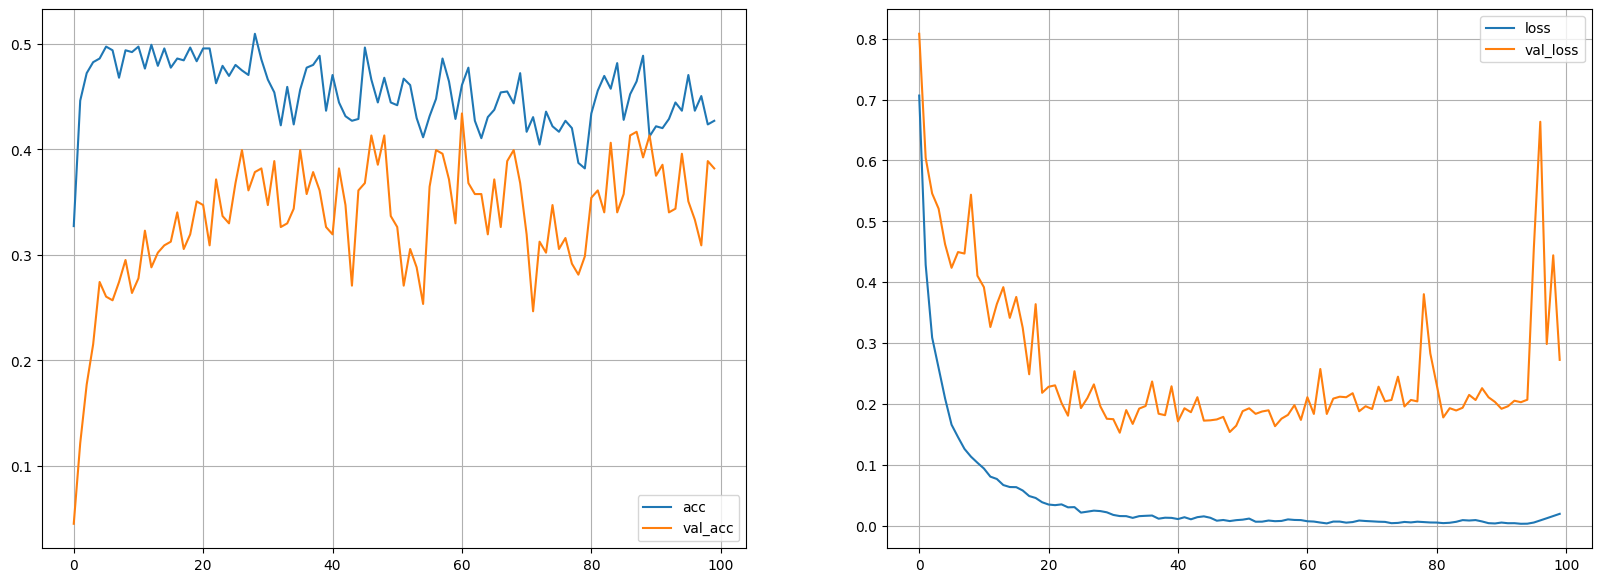

In [80]:
H = history.history
fig = plt.figure(figsize = (20, 7))
plt.subplot(121)
plt.plot(H['accuracy'], label = 'acc')
plt.plot(H['val_accuracy'], label = 'val_acc')
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(H['loss'], label = 'loss')
plt.plot(H['val_loss'], label = 'val_loss')
plt.grid()
plt.legend()

Kode di atas digunakan untuk memvisualisasikan performa model selama pelatihan. Berikut adalah penjelasan kode per baris:
1. `H = history.history`: Mengambil riwayat metrik evaluasi (akurasi dan loss) selama pelatihan dari objek `history` yang diperoleh dari fungsi `model.fit()`.
2. `fig = plt.figure(figsize=(20, 7))`: Membuat objek gambar dengan ukuran 20x7 inci menggunakan `plt.figure()`. Objek ini akan digunakan sebagai wadah untuk menampilkan grafik.
3. `plt.subplot(121)`: Membuat subplot pertama dengan posisi 1x2 dan memilih subplot pertama sebagai area grafik saat ini. Grafik akan ditampilkan di sebelah kiri.
4. `plt.plot(H['accuracy'], label='acc')`: Menampilkan grafik garis menggunakan data akurasi pelatihan (`H['accuracy']`) dengan label 'acc'. Garis ini merepresentasikan perubahan akurasi selama pelatihan pada setiap epoch.
5. `plt.plot(H['val_accuracy'], label='val_acc')`: Menampilkan grafik garis menggunakan data akurasi validasi (`H['val_accuracy']`) dengan label 'val_acc'. Garis ini merepresentasikan perubahan akurasi pada setiap epoch saat melakukan evaluasi pada subset validasi.
6. `plt.grid()`: Menambahkan grid pada grafik.
7. `plt.legend()`: Menampilkan legenda yang menjelaskan label-label pada grafik.
8. `plt.subplot(122)`: Membuat subplot kedua dengan posisi 1x2 dan memilih subplot kedua sebagai area grafik saat ini. Grafik akan ditampilkan di sebelah kanan.
9. `plt.plot(H['loss'], label='loss')`: Menampilkan grafik garis menggunakan data loss pelatihan (`H['loss']`) dengan label 'loss'. Garis ini merepresentasikan perubahan loss selama pelatihan pada setiap epoch.
10. `plt.plot(H['val_loss'], label='val_loss')`: Menampilkan grafik garis menggunakan data loss validasi (`H['val_loss']`) dengan label 'val_loss'. Garis ini merepresentasikan perubahan loss pada setiap epoch saat melakukan evaluasi pada subset validasi.
11. `plt.grid()`: Menambahkan grid pada grafik.
12. `plt.legend()`: Menampilkan legenda yang menjelaskan label-label pada grafik.

Dengan demikian, kode tersebut menghasilkan grafik yang menunjukkan perubahan akurasi dan loss selama pelatihan model, serta akurasi dan loss pada subset validasi. Grafik ini membantu dalam menganalisis dan memonitor performa model serta melihat apakah terjadi overfitting atau underfitting.

# Memprediksi gambar dataset uji

7/7 [==============================] - 1s 71ms/step


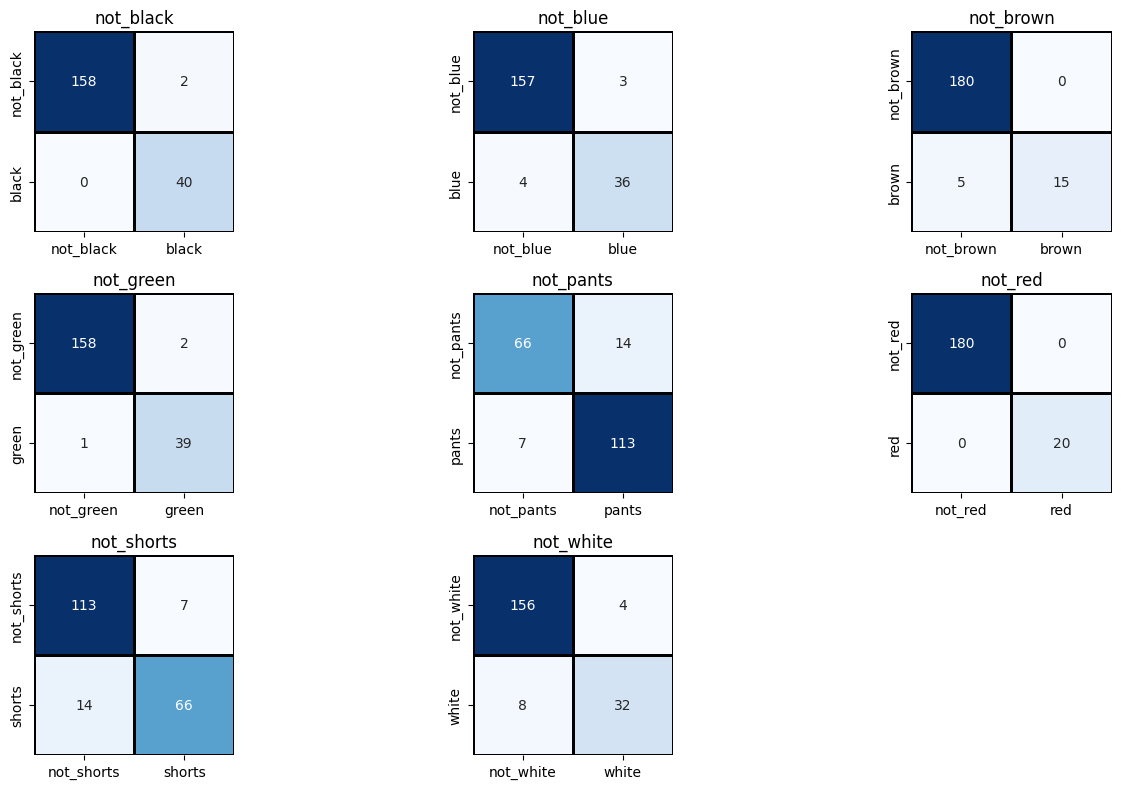

In [81]:
model.load_weights('../working/best_model.hdf5')

model.save('../working/model.hdf5')

preds = model.predict(test_x)
preds = np.where(preds < 0.5, 0, 1)

confusion = multilabel_confusion_matrix(test_y, preds)

fig = plt.figure(figsize=(14, 8))
num_subplots = len(mlb.classes_)
grid_size = math.ceil(math.sqrt(num_subplots))

for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    plt.subplot(grid_size, grid_size, i+1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues', 
                xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

Kode di atas digunakan untuk melakukan beberapa tugas sebagai berikut:
1. `model.load_weights('../working/best_model.hdf5')`: Memuat bobot (weights) terbaik yang disimpan sebelumnya dari file 'best_model.hdf5' ke model yang sudah didefinisikan sebelumnya.
2. `model.save('../working/model.hdf5')`: Menyimpan model saat ini ke file 'model.hdf5'. Ini digunakan untuk menyimpan seluruh arsitektur model dan bobot yang telah dilatih sehingga dapat digunakan di waktu berikutnya tanpa melatih ulang.
3. `preds = model.predict(test_x)`: Melakukan prediksi pada data uji (`test_x`) menggunakan model yang telah dilatih.
4. `preds = np.where(preds < 0.5, 0, 1)`: Mengubah nilai-nilai prediksi (`preds`) menjadi 0 jika nilai prediksi kurang dari 0.5, dan menjadi 1 jika nilai prediksi lebih dari atau sama dengan 0.5. Hal ini berguna untuk melakukan pembineran (binarization) pada hasil prediksi menjadi kelas biner.
5. `confusion = multilabel_confusion_matrix(test_y, preds)`: Menghitung matriks kebingungan (confusion matrix) berdasarkan nilai sebenarnya (`test_y`) dan nilai prediksi (`preds`). Fungsi `multilabel_confusion_matrix()` digunakan karena masalah ini merupakan masalah klasifikasi multilabel, yaitu setiap sampel dapat memiliki beberapa kelas yang relevan.
6. `fig = plt.figure(figsize=(14, 8))`: Membuat objek gambar dengan ukuran 14x8 inci menggunakan `plt.figure()`. Objek ini akan digunakan sebagai wadah untuk menampilkan grafik.
7. `num_subplots = len(mlb.classes_)`: Menghitung jumlah subplot yang akan digunakan berdasarkan jumlah kelas yang ada dalam masalah multilabel (`mlb.classes_`).
8. `grid_size = math.ceil(math.sqrt(num_subplots))`: Menghitung ukuran grid untuk menempatkan subplot-subplot. Ini dihitung sebagai akar kuadrat dari jumlah subplot yang dibulatkan ke atas menggunakan fungsi `math.ceil()`.
9. `for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):`: Melakukan iterasi melalui kelas-kelas (`mlb.classes_`) dan matriks kebingungan (`confusion`) menggunakan fungsi `enumerate()` dan `zip()`. Variabel `i` akan menyimpan nomor iterasi saat ini, `label` akan menyimpan nama kelas, dan `matrix` akan menyimpan matriks kebingungan untuk kelas tersebut.
10. `plt.subplot(grid_size, grid_size, i+1)`: Membuat subplot dengan posisi sesuai dengan nomor iterasi saat ini.
11. `labels = [f'not_{label}', label]`: Menyusun label-label untuk sumbu x dan y pada heatmap. Label pertama adalah "not_" diikuti dengan nama kelas, dan label kedua adalah nama kelas itu sendiri.
12. `sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues', xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1
)`: Membuat heatmap (peta panas) dari matriks kebingungan (`matrix`) menggunakan library seaborn (`sns.heatmap()`). Parameter lainnya seperti `annot`, `square`, `fmt`, `cbar`, `cmap`, `xticklabels`, `yticklabels`, `linecolor`, dan `linewidth` digunakan untuk mengatur penampilan heatmap.
13. `plt.title(labels[0])`: Mengatur judul subplot menggunakan label pertama dari variabel `labels`.
14. `plt.tight_layout()`: Mengatur tata letak subplot agar sesuai dan tidak tumpang tindih.
15. `plt.show()`: Menampilkan grafik yang telah dibuat.

Dengan demikian, kode ini menghasilkan sejumlah subplot yang menampilkan matriks kebingungan (confusion matrix) untuk setiap kelas pada masalah klasifikasi multilabel, membantu dalam menganalisis performa model untuk setiap kelas secara visual.

# Mencari Probabilitas dari Gambar

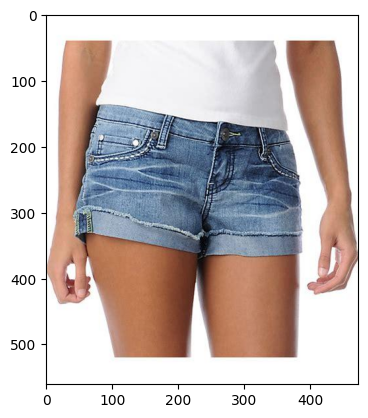

1/1 [==============================] - 0s 32ms/step
black: 0.05%
blue: 19.22%
brown: 1.12%
green: 0.00%
pants: 0.01%
red: 0.04%
shorts: 100.00%
white: 9.40%


In [82]:
new_image_path = 'D:/program/Smt4\pcd/praktikum/project/demo/blueshorts.jpg'
new_image = plt.imread(new_image_path)
plt.imshow(new_image)
plt.show()
if new_image is not None:
    
    new_image = cv.resize(new_image, (96, 96))
    new_image = new_image / 255.0
    new_image = np.expand_dims(new_image, axis=0)
    predictions = model.predict(new_image)
    labels = mlb.classes_
    probabilities = predictions[0] * 100

    for label, probability in zip(labels, probabilities):
        print(f"{label}: {probability:.2f}%")
else:
    print("Failed to load the image.")

Kode di atas digunakan untuk melakukan beberapa tugas sebagai berikut:
1. `new_image_path = 'D:/program/Smt4/pcd/praktikum/project/demo/blueshorts.jpg'`: Menyimpan path (lokasi) dari gambar baru yang akan diprediksi. Lokasi gambar tersebut ditentukan dalam variabel `new_image_path`.
2. `new_image = plt.imread(new_image_path)`: Membaca gambar dari path yang telah ditentukan menggunakan fungsi `plt.imread()`. Gambar tersebut akan dimuat ke dalam variabel `new_image`.
3. `plt.imshow(new_image)`: Menampilkan gambar yang telah dibaca menggunakan fungsi `plt.imshow()`. Ini akan menampilkan gambar dalam bentuk plot.
4. `plt.show()`: Menampilkan plot gambar yang telah ditampilkan sebelumnya.
5. `if new_image is not None:`: Memeriksa apakah gambar berhasil dimuat dengan memeriksa apakah `new_image` tidak bernilai `None`. Ini dilakukan untuk memastikan gambar berhasil dimuat sebelum melakukan prediksi.
6. `new_image = cv.resize(new_image, (96, 96))`: Mengubah ukuran gambar baru (`new_image`) menjadi ukuran yang sesuai dengan model yang telah dilatih. Ini dilakukan menggunakan fungsi `cv.resize()` dari library OpenCV (`cv`).
7. `new_image = new_image / 255.0`: Menormalkan piksel-piksel gambar baru dengan membaginya dengan 255.0. Hal ini dilakukan untuk mengubah rentang nilai piksel menjadi antara 0 hingga 1.
8. `new_image = np.expand_dims(new_image, axis=0)`: Menambahkan dimensi tambahan pada gambar baru (`new_image`) di posisi 0 (axis=0). Ini dilakukan karena model yang telah dilatih mengharapkan input dengan dimensi (batch_size, width, height, channels).
9. `predictions = model.predict(new_image)`: Melakukan prediksi pada gambar baru menggunakan model yang telah dilatih. Hasil prediksi akan disimpan dalam variabel `predictions`.
10. `labels = mlb.classes_`: Menyimpan daftar kelas yang digunakan oleh model untuk prediksi dalam variabel `labels`. `mlb.classes_` berisi nama-nama kelas.
11. `probabilities = predictions[0] * 100`: Mengalikan nilai prediksi dengan 100 untuk mengubahnya menjadi persentase probabilitas. Ini dilakukan untuk mendapatkan probabilitas prediksi untuk setiap kelas dalam bentuk persentase.
12. `for label, probability in zip(labels, probabilities):`: Melakukan iterasi melalui pasangan label dan probabilitas menggunakan fungsi `zip()`. Variabel `label` akan menyimpan nama kelas, dan `probability` akan menyimpan nilai probabilitas yang telah diubah menjadi persentase.
13. `print(f"{label}: {probability:.2f}%")`: Mencetak label kelas dan probabilitasnya dengan format yang telah ditentukan. `:.2f` digunakan untuk membatasi angka desimal menjadi 2 digit setelah koma.
14. `else: print("Failed to load the image.")`: Menampilkan pesan "Failed to load the image." jika gambar gagal dimuat.

Dengan demikian, kode ini membaca, menampilkan, dan melakukan prediksi pada gambar baru menggunakan model yang telah dilatih, dan kemudian mencetak hasil prediksi (kelas dan probabilitas) pada layar.